# Van der Pol Neural ODE experiment

Based on [rtqichen/torchdiffeq/examples/ode_demo](https://github.com/rtqichen/torchdiffeq/blob/19a8c703676fd5039b4d45a8d1f27776463945bb/examples/ode_demo.py).
Note that this notebook does not export any trained model, is only for experimenting and demonstration. To train and save a model use the `train.py` script.

In [1]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim
import matplotlib.pyplot as plt

%matplotlib notebook

from torchdiffeq import odeint as odeint

dirname="data"
test_freq=100
data_size=1000
batch_time=10
batch_size=100
gpu = 0

torch.set_default_dtype(torch.float64)

if not os.path.exists(dirname):
    os.makedirs(dirname)

In [2]:
#select device
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

#initial condition
true_y0 = torch.tensor([[1., 1.]]).to(device)
#
t = torch.linspace(0., 30., data_size).to(device)

In [3]:
class Lambda(nn.Module):
    '''The ODE function of Van der Pol'''

    def forward(self, t, y):
        dydt = torch.ones(1,2)
        dydt[0,0] = -1.5 * (y[0,1]*y[0,1] - 1.0) * y[0,0] - y[0,1]
        dydt[0,1] = y[0,0]
        return dydt

#solving the original ODE
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5', rtol=1e-6, atol=1e-6)

In [4]:
def get_batch():
    #random data indices
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False)) 
    #exact values -> initial conditions
    batch_y0 = true_y[s]  # (M, D)
    #time points
    batch_t = t[:batch_time]  # (T)
    #all together
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


In [5]:
def visualize(true_y, pred_y, odefunc, itr):

        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--')
        ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
        ax_traj.set_ylim(-5, 5)
        #ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-5, 5)
        ax_phase.set_ylim(-5, 5)

        ax_vecfield.cla()
        ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-5:5:21j, -5:5:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(-5, 5)
        ax_vecfield.set_ylim(-5, 5)

        fig.tight_layout()
        #plt.savefig('png/{:03d}'.format(itr))
        fig.canvas.draw()
        plt.pause(0.01)

### Neural Network

In [6]:
#neural network
class ODEFunc(nn.Module):

    def __init__(self, num_in_features, num_out_features):
        super(ODEFunc, self).__init__()
        self.act    = nn.ELU()
        
        self.l_in   = nn.Linear(
            in_features = num_in_features,
            out_features= 50
        )
        self.l1   = nn.Linear(
            in_features = 50,
            out_features= 100
        )
        self.l2   = nn.Linear(
            in_features = 100,
            out_features= 50
        )
        self.l3   = nn.Linear(
            in_features = 50,
            out_features= 100
        )
        self.l_out   = nn.Linear(
            in_features = 100,
            out_features= num_out_features
        )

    def forward(self, t, y):
        x = self.act(self.l_in(y))
        x = self.act(self.l1(x));
        x = self.act(self.l2(x));
        x = self.act(self.l3(x));
        return self.l_out(x)


<IPython.core.display.Javascript object>


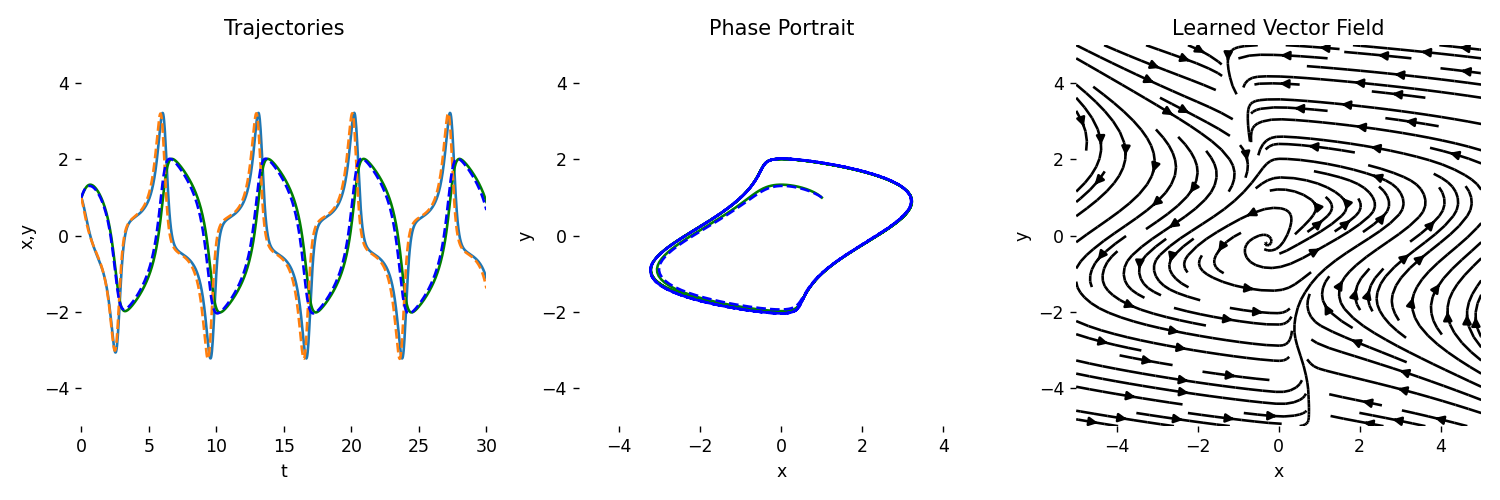

In [7]:
#plot init
plt.ion()
fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_traj = fig.add_subplot(131, frameon=False)
ax_phase = fig.add_subplot(132, frameon=False)
ax_vecfield = fig.add_subplot(133, frameon=False)

In [ ]:
#real stuff
ii = 0
func = ODEFunc(2,2).to(device)
    
optimizer = torch.optim.Adam(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, 10000):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    smallest_loss = 1e100
    if itr % test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            if loss.item() < smallest_loss:
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()